In [1]:
from typing import Tuple, Dict, Optional
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

# are the principal components of the covariance matrix the same as those of the correlation?

Short answer: No! Upshot? In general, always consider standardizing your features before running PCA! This is very different than the common knowledge in the OLS linear regression setting that shifting or scaling your regressors will just cause the $\hat{\beta}'s$ to shift or scale themselves to compensate and recover the "same" model.

# setting

## $x$

Suppose we have an $N$-dimensional standard real random vector
$x := (x_0,\, x_1,\, \dots,\, x_{N-1})'$.
By "standard", we mean that $\mu := E[x] = 0$
and
$\sigma := \sigma(x) = 1$.
The ideas we're going to cover are more general than this,
but for simplicity let's encode our distribution
into the $T \times N$ matrix $X$:
Each row of $X$ represents a possible draw
$a$ (a fixed vector in $R^N$)
of
$x$ (our random vector in $R^N$).
We have $\Pr[x = a]$ is the
number of times $a'$ appears as a row of $X$
(there can---and in general must be---be
multiple copies of the same row),
divided by the total number of rows.
That is,
$$ \Pr[x = a] = \frac{1}{T} \sum_{t=0}^{T-1} I[X_t = a'] ,$$
where $I[X_t = a']$ indicates whether row $t$ of $X$ is equal to $a'$.
(For your own comfort, note that
we can make $X$ encode _any_ probability distribution
with vanishing error by letting $T \to \infty$.)
The covariance matrix
(which also happens to be $x$'s correlation matrix)
can be calculated as
$$ \Omega = X'X ,$$
but for simplicity we will just specify it directly.

In [2]:
# correlation
omega = 0.5
Omega = pd.DataFrame({
    "X0": {"X0": 1    , "X1": omega},
    "X1": {"X0": omega, "X1": 1    }
})
Omega

,X0,X1
X0,1.0,0.5
X1,0.5,1.0


## $y$

Now, we create a new random vector $y$ by (possibly non-uniformly)
scaling the entries of $x$
by some vector $\delta \in R^N$.
This can be non-uniform because
the $n$th entry of $\delta$ gives the scalar applied to the $n$th entry of $x$,
and we allow the $\delta_n$'s to be different.
(Think of the entries of $x$ as a mix of measurements of different quantities,
with $\delta$ specifying how to convert units e.g
weights from kg to lbs,
distances from km to mi,
volumes from L to gal.)
We define the $N \times N$ matrix $\Delta$ as the diagonal matrix
with the $n$th entry of $\delta$ as the $(n,n)$th entry of $\Delta$.
We can encode $y$'s distribution as the matrix
$$ Y := X \Delta .$$
So, $X$ used to be "shaped" like a "blob" or "cloud" of $T$ points in $R^N$,
and to create $Y$ we have deformed that cloud.
The covariance matrix of $y$ is
$$ \Sigma = Y'Y = (X \Delta)' (X \Delta) = \Delta' X' X \Delta = \Delta \Omega \Delta $$
(since $\Delta$ is diagonal, $\Delta' = \Delta$),
while its correlation matrix is still just $\Omega$.

In [3]:
delta = pd.Series({"X0": 1, "X1": 2})
# diagonal square matrix with standard deviations along diagonal
Delta = pd.DataFrame(
    np.diag(delta),
index=delta.index, columns=delta.index)
Delta

,X0,X1
X0,1,0
X1,0,2


In [4]:
Sigma = Delta @ Omega @ Delta
Sigma

,X0,X1
X0,1.0,1.0
X1,1.0,4.0


# principal components (eigendecompositions)

Now, for $N \geq 2$, there are an infinite number of
orthonormal bases of $R^N$.
(The case $N=1$ is uninteresting as there
are only two possible orthonormal bases, namely
$\{(1,)',\}$ and $\{(-1,)',\}$, both of which are
essentially the same thing.)
The PC's of the space w.r.t. $x$
are a particular ordered ONB that are most
"efficient" at describing (we say, "explaining") the distribution of $x$.
(The normalization isn't strictly necessary, but
the universe smiles when you do it.)
They are ordered such that the first PC is the most "efficient",
the second PC is next-most efficient given the first, and so on.

The PC's of a random variable turn out
to be the normalized eigenvectors of its covariance matrix,
ranked by their respective eigenvalues.
So, the PC's of $x$ are the sorted normalized eigendecomposition
of $\Omega$, while the PC's of $y$ are
the sorted normalized eigendecomposition of $\Sigma$.

Algebraically, we can see that the new eigenvectors won't be the same:
We know that $\Sigma = \Delta \Omega \Delta$,
so consider $v$ (a fixed column vector in $R^N$)
where $v$ is an eigenvector of $\Omega$, i.e.
$\Omega v = k v$ where $k$ is some scalar in $R$.
Now let's consider
$$ \Sigma v = \Delta \Omega \Delta v .$$
Immediately, we run into an issue:
We want to apply $\Omega$ to $v$, but
instead we're applying it to $\Delta v$.
Alright, let's remedy the issue:
We'll let ourselves relax a bit, and concede that $v$
might not be an eigenvector of $\Sigma$, but
maybe we just need to "distort" or "stretch" it
the same way we did the data.
So: Let's try $u := \Delta v$. We have:
$$ \Sigma u = \Delta \Omega \Delta (\Delta v) $$
$$ = \Delta \Omega \Delta^2 v \;...$$
Crap. All we've done is compound the problem.

Ok fine: $v$ wasn't an eigenvector of $\Sigma$,
and neither was $\Delta v$.
However, surely $u := \Delta^{-1} v$ will be!
Instead of "applying" the scaling to $v$,
this "undoes" them.
Let's try _this_ out: We have,
$$ \Sigma u = \Delta \Omega \Delta (\Delta^{-1} v) $$
$$ = \Delta \Omega v $$
$$ = \Delta k v $$
$$ = k \Delta v \;...$$
Dammit! We wanted something like $\Sigma u = k u = k \Delta^{-1} v$,
but instead of $\Delta^{-1}$ in the middle, god laughed in our face
and gave us its inverse.
(Try $u := \Delta^{-2}v$ and convince yourself that it won't work either.)

(Adventitiously, because non-uniform scaling is not angle-preserving,
the set $\{ \dots,\, \Delta v_n,\, \dots \}$ where $v_n$ is the $n$th
eigenvector of $x$ isn't guaranteed to be normalized or even orthogonal anymore.)


## the kicker

This is a pretty strong and amazing statement:
Simply by changing the units of our measurements,
we have fundamentally altered their "explanation"!

In [5]:
def inv(mat: pd.DataFrame) -> pd.DataFrame:
    ix, cols = mat.index, mat.columns
    mat = np.linalg.inv(mat)
    mat = pd.DataFrame(mat, index=ix, columns=cols)
    return mat

def _eig(mat: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Eigendecompose `mat`, returning eigenvalues `W` and corresponding eigenvectors `V`,
    such that the eigenvector associated with eigenvalue `W[n]` is `V[:, n]`.
    """
    W, V = np.linalg.eig(mat)
    W = pd.Series(W)
    V = pd.DataFrame(V, index=mat.index)
    # sort in order of explained variance, then reorder v to match
    W = W.sort_values(ascending=False)
    V = V.reindex(columns=W.index)
    # the order it came out of `np.eig` is not meaningful, drop it
    W = W.reset_index(drop=True)
    V = V.T.reset_index(drop=True).T  # stupid hack, there is no `pd.DataFrame.reset_columns()`
    # make the column names more suggestive
    W = W.rename(index=lambda n: f"E{n}")
    V = V.rename(columns=lambda n: f"E{n}")
    # i hate vectors with negative heads, so if i find one, negate the entire vector
    sign_of_V_heads = np.sign(V.loc["X0", :])
    V = V.mul(sign_of_V_heads, axis="columns")
    return W, V

def eig(mat: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame]:
    """Like `eig()` but with side effects :)."""
    W, V = _eig(mat=mat)
    print(W)
    print()
    print(V)
    return W, V

## correlation

In [6]:
W_Omega, V_Omega = eig(mat=Omega)

E0    1.5
E1    0.5
dtype: float64

          E0        E1
X0  0.707107  0.707107
X1  0.707107 -0.707107


## covariance

In [7]:
W_Sigma, V_Sigma = eig(mat=Sigma)

E0    4.302776
E1    0.697224
dtype: float64

          E0        E1
X0  0.289784  0.957092
X1  0.957092 -0.289784


## entrywise ratio of cov PC's to corr PC's, and vice versa

In [8]:
V_Sigma / V_Omega

,E0,E1
X0,0.409817,1.353533
X1,1.353533,0.409817


In [9]:
V_Omega / V_Sigma

,E0,E1
X0,2.440115,0.738808
X1,0.738808,2.440115


# visualization

In [10]:
def get_data(cov: pd.DataFrame, label: str="x", T: int=2**16) -> pd.DataFrame:
    N = len(cov)
    mu = [0,]*N
    np.random.seed(1337)
    data = stats.multivariate_normal.rvs(mean=mu, cov=cov, size=T)
    data = pd.DataFrame(data, columns=[f"{label}{n}" for n in range(N)])
    data.name = label.upper()
    return data


Axes = plt.matplotlib.axes.Axes

def _plot_V(V: pd.DataFrame, color: str="blue", ax: Optional[Axes]=None):
    V = 32*V  # scale it visually
    v0 = V.iloc[:, 0]
    v0 = pd.Series({-v0[0]: -v0[1], v0[0]: v0[1]}, name="E0")
    v1 = V.iloc[:, 1]
    v1 = pd.Series({-v1[0]: -v1[1], v1[0]: v1[1]}, name="E0")
    cols = V.columns
    V = pd.DataFrame({0: v0, 1: v1}).rename(columns=lambda c: cols[c])
    V = V.interpolate(method="index")
    ax = V.plot(color=color, style=["-", "--"], ax=ax)
    return ax

def _plot_data(data: pd.DataFrame, V: pd.DataFrame, _V: pd.DataFrame=None, __V: pd.DataFrame=None,
               lim=(-8, 8), ax: Optional[Axes]=None) -> Axes:
    N = len(data.columns)
    ax = data.plot(kind="scatter", *data.columns, c="green", alpha=0.125, title=data.name, ax=ax)
    # plot PC's
    if __V is not None:
        ax = _plot_V(V=__V, color="red", ax=ax)
    if _V is not None:
        ax = _plot_V(V=_V, color="orange", ax=ax)
    ax = _plot_V(V, ax=ax)
    # fmt
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_box_aspect(1)
    return ax

def plot_data(datas: Tuple[Dict[str, Optional[pd.DataFrame]]]):
    _, axs = plt.subplots(ncols=len(datas), sharex=True, sharey=True, figsize=(16, 32))
    for d, data in enumerate(datas):
        ax = _plot_data(**data, ax=axs[d])
    plt.show()

## what gives?

So. It turns out, that the "easy" things we thought to do---either apply the scaling to the original PC's (red), or reverse-scale the original PC's (orange)---result in vectors that do span the space and so are a basis, but aren't even orthogonal. They can't possibly be the most efficient orthonormal basis w.r.t $y$ because they aren't even orthogonal.

In the original data, the standard deviation of $x_1$ ($\propto$ height of the lefthand cloud) was the same as the standard deviation of $x_0$ ($\propto$ width of the lefthand cloud). So, the PC's just had to explain the correlation structure. However, in the new data, the standard deviation of $y_1$ is much greater (in fact, double) the standard deviation of $y_0$. This of course means that the variance of $y_1$ is actually _quadruple_ the variance of $y_0$! And because the PC's are supposed to explain the _variance_ of the data, the first PC gets "yanked" closer to a vertical line (compare the solid blue line on the RHS, which is the new first PC, to the solid red line on the RHS, which is the scaled original first PC).

At the margin, the first PC needs to "focus" on explaining variance of $y_1$ much more than the variance of $y_0$, because it's 4x bigger. The naive scaling of the original first PC helps as it stretches it vertically, but this isn't quite enough.

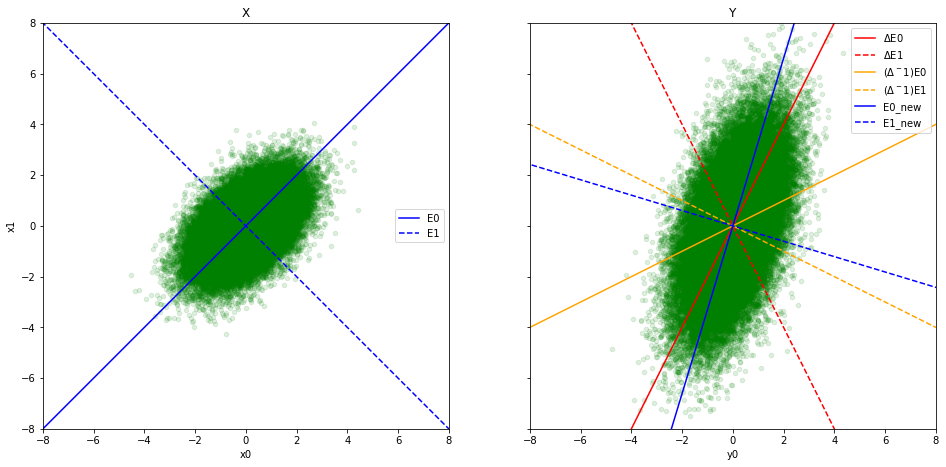

In [12]:
X = get_data(cov=Omega, label="x")
X = {"data": X,
     "V": V_Omega}
Y = get_data(cov=Sigma, label="y")
Y = {"data": Y,
     "V": V_Sigma.rename(columns=lambda c: f"{c}_new"),
     "_V": (inv(Delta) @ V_Omega).rename(columns=lambda c: f"$(\Delta^{-1})${c}"),
     "__V": (Delta @ V_Omega).rename(columns=lambda c: f"$\Delta${c}")}
plot_data(datas=(X, Y))